# Delivery Duration Prediction — Project Proposal
- **Course:** DSCI 631 — Applied Machine Learning for Data Science
- **Author:** Ian Auger
- **Dataset:** DoorDash Delivery Data
- **Date:** October 2025

---

## Introduction  

Accurately estimating delivery times is a critical challenge for food delivery platforms such as DoorDash. Underestimating delivery duration can lead to poor customer experiences, increased refund rates, and operational inefficiencies, while overestimation may reduce order volume due to inflated wait times.  

This project aims to build a predictive model that estimates *total delivery duration* using historical DoorDash order data. Each record represents a completed delivery, capturing order-level, store-level, and marketplace features such as total items, dasher availability, outstanding orders, and estimated travel times.  

Beyond simply predicting average duration, the broader goal is to identify which factors most strongly influence delivery reliability, helping to illustrate how machine learning can support operational decision-making in real-world contexts.

---

## Objectives  

1. **Predictive Goal:**  
   Develop a **regression** model to predict total delivery duration between order creation and delivery completion.  

2. **Analytical Goal:**  
   Identify operational and order-level variables that most impact delivery efficiency, focusing on congestion and fulfillment dynamics.  

3. **MLOps Perspective:**  
   Implement the project using a modular pipeline structure (data ingestion, preprocessing, feature engineering, modeling) to demonstrate reproducibility and scalability, while potentially integrating lightweight MLOps tools (e.g., ZenML, Prefect, or MLflow) in later phases. This objective is aimed at producing a project that can effectively demonstrate MLOps fundamentals for future employers. 

---

## Dataset Overview  

The dataset, published by DoorDash as part of a data science recruitment assessment, contains approximately 197,000 delivery records from early 2015. Each observation includes:  

- **Time features:** order creation and completion timestamps (`created_at`, `actual_delivery_time`).  
- **Order features:** total items, distinct items, subtotal, min/max item price.  
- **Marketplace features:** total dashers on shift, busy dashers, outstanding orders within 10 miles.  
- **Model estimates:** predicted prep time and store-to-consumer drive duration.  

The target variable is computed as the time difference (in seconds) between `created_at` and `actual_delivery_time`.  

---

## Proposal Structure  

1. **Data Loading & Cleaning:**  
   Using a custom `DataLoader` class to enforce schema consistency, cast dtypes, and compute derived features.  

2. **Exploratory Data Analysis (EDA):**  
   Summarize data completeness, distribution of the target variable, and some partial sampling of relationships between operational and categorical features.  

3. **Modeling Plan:**  
   Outline intended regression approaches (e.g., Random Forest, LightGBM, and Linear Regression baselines), evaluation metrics (MAE, RMSE, R²), and proposed validation framework.  

---



In [ ]:
# Standard libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to sys.path for module imports
project_root = Path.cwd().parent
if project_root not in sys.path:
    sys.path.append(str(project_root))

# Module imports
from src.data_loader import DataLoader



## Data Loading and Cleaning

To ensure reproducibility and data integrity, a modular data ingestion workflow was developed using a custom DataLoader class. This design separates I/O, validation, and preprocessing logic from exploratory and modeling notebooks, creating a clear foundation for future MLOps integration. The project will continue to follow this modular approach, emphasizing single-responsibility principles and clean, maintainable code throughout development.

### Objectives

1. **Consistent Schema Enforcement:**  
   Enforce strict data typing to ensure all columns conform to expected formats while minimizing memory footprint for downstream modeling. Dtypes such as nullable integers (`Int8`, `Int16`), 32-bit floats (`Float32`), and pandas string types are used to balance precision and efficiency.

2. **Reusable Data Utility Functions:**  
   Begin constructing utility functions that will be reused throughout the project to maintain consistent data handling, encoding, and compression practices. Multiple iterations of the dataset will be generated across cleaning, feature engineering, and modeling stages, so reusability is essential for consistency and traceability.

3. **Descriptive and Structural Validation:**  
   Evaluate descriptive statistics, identify missing values, and detect clear outliers to confirm that the loaded data aligns with schema expectations. These checks ensure early visibility into data quality issues and guide subsequent cleaning and feature engineering efforts.
   


In [3]:
# Load raw data
data_path = Path(project_root / "data" / "raw" / "historical_data.csv")
data_loader = DataLoader(data_path)
data = data_loader.load_data().reset_index()
print(data.info())
print(display(data.describe(include=[np.number]).T.round(2)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   index                                         197428 non-null  int64         
 1   market_id                                     196441 non-null  string        
 2   created_at                                    197428 non-null  datetime64[ns]
 3   actual_delivery_time                          197421 non-null  datetime64[ns]
 4   store_id                                      197428 non-null  string        
 5   store_primary_category                        192668 non-null  string        
 6   order_protocol                                196433 non-null  Int8          
 7   total_items                                   197428 non-null  Int16         
 8   subtotal                                      197428 n

,count,mean,std,min,25%,50%,75%,max
index,197428.0,98713.5,56992.69881,0.0,49356.75,98713.5,148070.25,197427.0
order_protocol,196433.0,2.882352,1.503771,1.0,1.0,3.0,4.0,7.0
total_items,197428.0,3.196391,2.666546,1.0,2.0,3.0,4.0,411.0
subtotal,197428.0,2682.331543,1823.09375,0.0,1400.0,2200.0,3395.0,27100.0
num_distinct_items,197428.0,2.670791,1.630255,1.0,1.0,2.0,3.0,20.0
min_item_price,197428.0,686.218506,522.038635,-86.0,299.0,595.0,949.0,14700.0
max_item_price,197428.0,1159.588623,558.411377,0.0,800.0,1095.0,1395.0,14700.0
total_onshift_dashers,181166.0,44.808093,34.526783,-4.0,17.0,37.0,65.0,171.0
total_busy_dashers,181166.0,41.739747,32.145733,-5.0,15.0,34.0,62.0,154.0
total_outstanding_orders,181166.0,58.050065,52.66183,-6.0,17.0,41.0,85.0,285.0


None


## Exploratory Data Analysis (EDA)

Following initial data validation and cleaning, exploratory data analysis was conducted to better understand feature behavior, data completeness, and the operational factors driving delivery duration.  
The goal of this phase was not only to identify modeling challenges such as skewness or outliers but also to uncover patterns that reveal the underlying business and operational dynamics of the DoorDash delivery process.

### Objectives

1. **Assess Data Completeness and Quality:**  
   Visualize and quantify missing data across all columns to identify features requiring imputation or exclusion. Missing data was found primarily in marketplace telemetry fields (e.g., on-shift and busy dashers), while order-level and timestamp fields were largely complete.

2. **Understand Target Variable Distribution:**  
   Examine the distribution of `delivery_duration` to evaluate its central tendency, variance, and presence of outliers. The variable was right-skewed, with most deliveries completed between 45 and 60 minutes. Applying a log transformation (`log1p`) produced a near-normal distribution, making it suitable for regression modeling.

3. **Explore Operational Relationships:**  
   Investigate how marketplace and order-level variables (e.g., `total_outstanding_orders`) influence delivery duration. The number of outstanding orders showed a modest positive relationship with duration, consistent with congestion effects.

4. **Examine Categorical and Geographic Factors:**  
   Compare delivery times across restaurant types and regional markets using boxplots. Median durations were very consistent across cuisine categories and markets, indicating that these static attributes have limited influence on delivery time compared to real-time operational load.

### Summary

Overall, the EDA suggests that delivery performance is primarily influenced by dynamic, real-time conditions, while restaurant and market variables show weaker relationships. This represents a strong starting point for understanding the dataset, though additional exploratory analysis and extensive feature engineering will be required to fully capture the drivers of delivery performance in subsequent modeling phases.

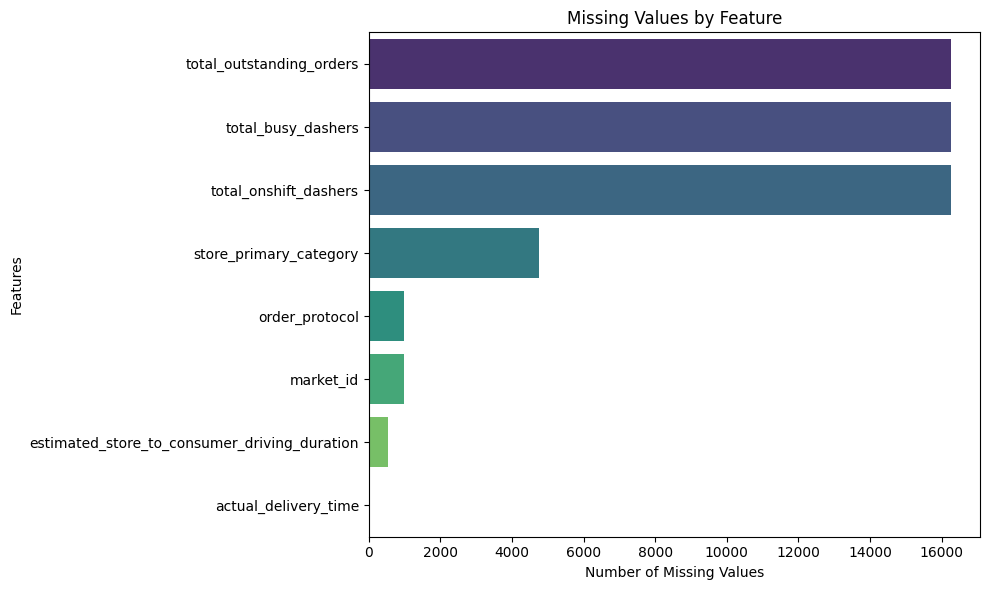

In [34]:
# Pull out missing data information
missing = data.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

# Convert to DataFrame for visualization
missing_df = missing.reset_index()
missing_df.columns = ["feature", "missing_count"]

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.barplot(x="missing_count", y="feature", data=missing_df, hue="feature", palette="viridis", legend=False)
plt.title("Missing Values by Feature")
plt.xlabel("Number of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

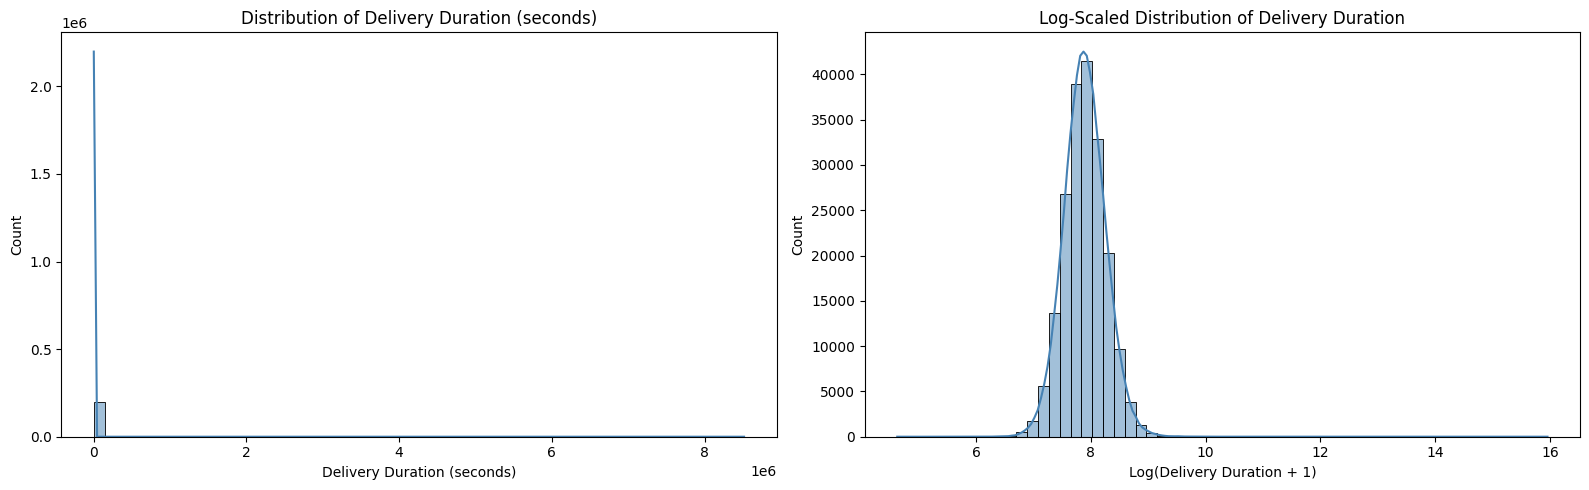

In [ ]:
# Calculate the target variable
data["delivery_duration"] = (
    data["actual_delivery_time"] - data["created_at"]
).dt.total_seconds()

fig, axes = plt.subplots(1, 2, figsize=(16, 5), squeeze=False)
axes = axes.ravel()

# Visualize the distribution of the target variable
sns.histplot(x = data["delivery_duration"], bins=60, kde=True, color="steelblue", ax=axes[0])
axes[0].set_title("Distribution of Delivery Duration (seconds)")
axes[0].set_xlabel("Delivery Duration (seconds)")
axes[0].set_ylabel("Count")

# Visualize the distribution of the log scaled target variable
sns.histplot(x = np.log1p(data["delivery_duration"]), bins=60, kde=True, color="steelblue", ax=axes[1])
axes[1].set_title("Log-Scaled Distribution of Delivery Duration")
axes[1].set_xlabel("Log(Delivery Duration + 1)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

c:\Users\iauge\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs2, **kwargs)
c:\Users\iauge\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs2, **kwargs)


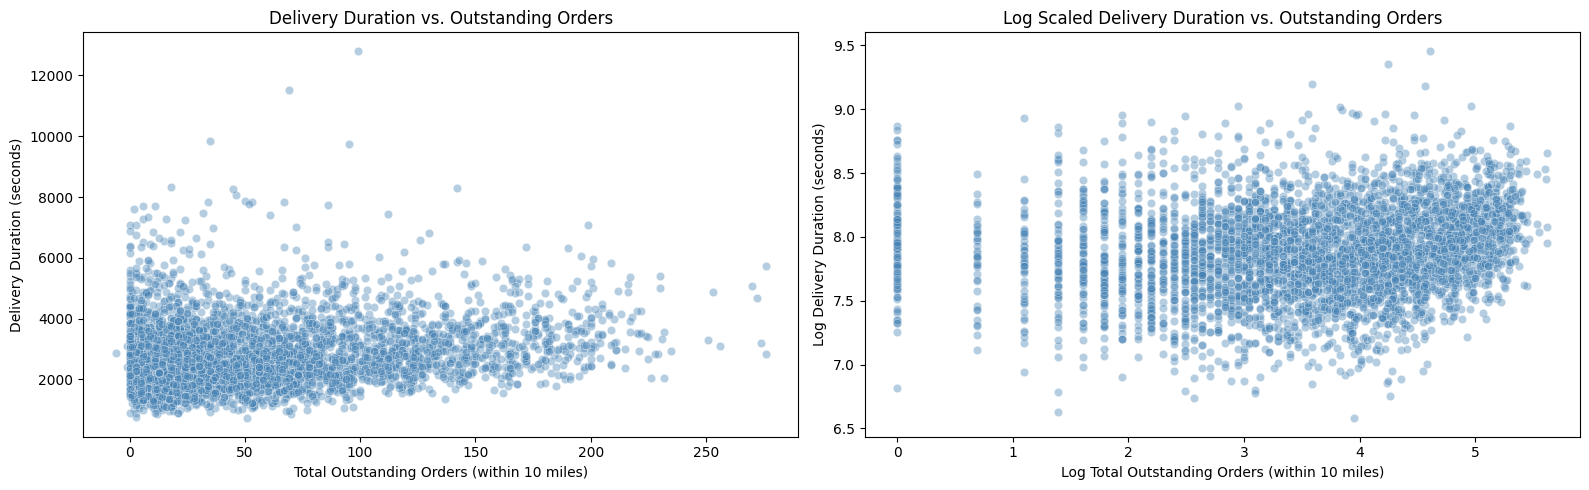

In [ ]:

sample_df = data.sample(5000, random_state=42).copy()
sample_df = sample_df[['total_outstanding_orders', 'delivery_duration']].dropna()

sample_df['log_total_outstanding_orders'] = np.log1p(sample_df['total_outstanding_orders'])
sample_df['log_delivery_duration'] = np.log1p(sample_df['delivery_duration'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5), squeeze=False)
axes = axes.ravel()

sns.scatterplot(
    x='total_outstanding_orders',
    y='delivery_duration',
    data=sample_df,
    alpha=0.4,
    color='steelblue',
    ax=axes[0]
)
axes[0].set_title('Delivery Duration vs. Outstanding Orders')
axes[0].set_xlabel('Total Outstanding Orders (within 10 miles)')
axes[0].set_ylabel('Delivery Duration (seconds)')

sns.scatterplot(
    x='log_total_outstanding_orders',
    y='log_delivery_duration',
    data=sample_df,
    alpha=0.4,
    color='steelblue',
    ax=axes[1]
)
axes[1].set_title('Log Scaled Delivery Duration vs. Outstanding Orders')
axes[1].set_xlabel('Log Total Outstanding Orders (within 10 miles)')
axes[1].set_ylabel('Log Delivery Duration (seconds)')

plt.tight_layout()
plt.show()

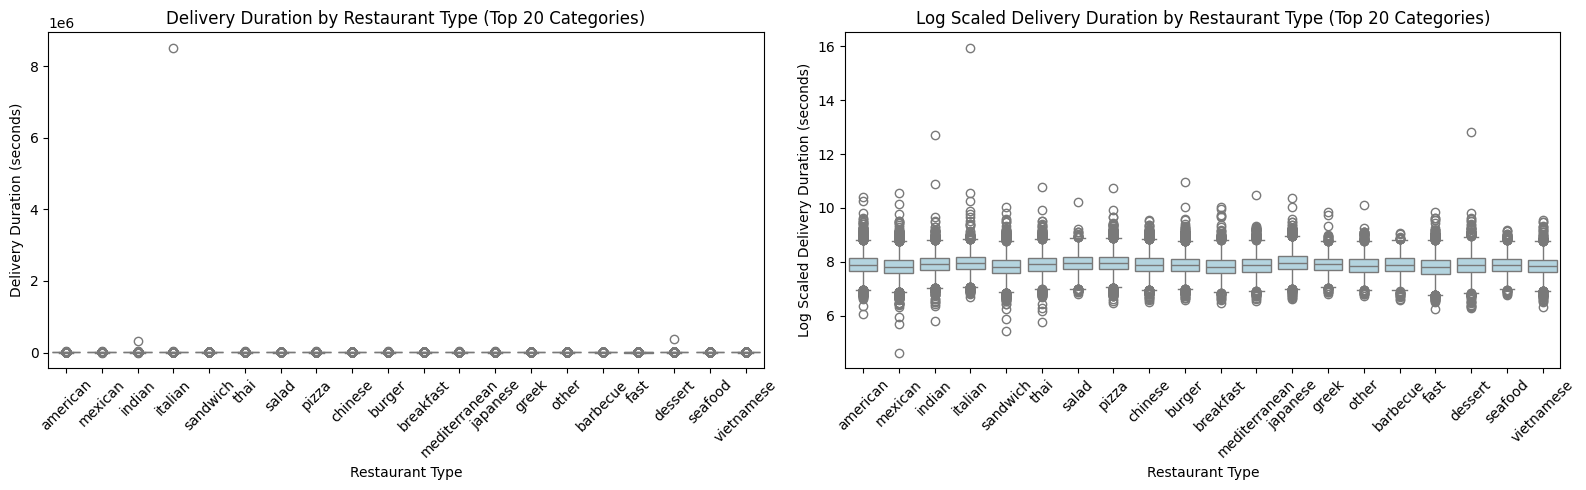

In [52]:
# Select top 10 restaurant categories for visualization
top_categories = (
    data["store_primary_category"].value_counts()
    .head(20)
    .index
)

# Subset data and compute log-transformed delivery duration
df_plot = data[data["store_primary_category"].isin(top_categories)].copy()
df_plot["log_delivery_duration"] = np.log1p(df_plot["delivery_duration"])

# Create side-by-side boxplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), squeeze=False)
axes = axes.ravel()

# Raw scale
sns.boxplot(
    x="store_primary_category",
    y="delivery_duration",
    data=df_plot,
    color="lightblue",
    ax=axes[0]
)
axes[0].set_title("Delivery Duration by Restaurant Type (Top 20 Categories)")
axes[0].set_xlabel("Restaurant Type")
axes[0].set_ylabel("Delivery Duration (seconds)")
axes[0].tick_params(axis="x", rotation=45)

# Log scale
sns.boxplot(
    x="store_primary_category",
    y="log_delivery_duration",
    data=df_plot,
    color="lightblue",
    ax=axes[1]
)
axes[1].set_title("Log Scaled Delivery Duration by Restaurant Type (Top 20 Categories)")
axes[1].set_xlabel("Restaurant Type")
axes[1].set_ylabel("Log Scaled Delivery Duration (seconds)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


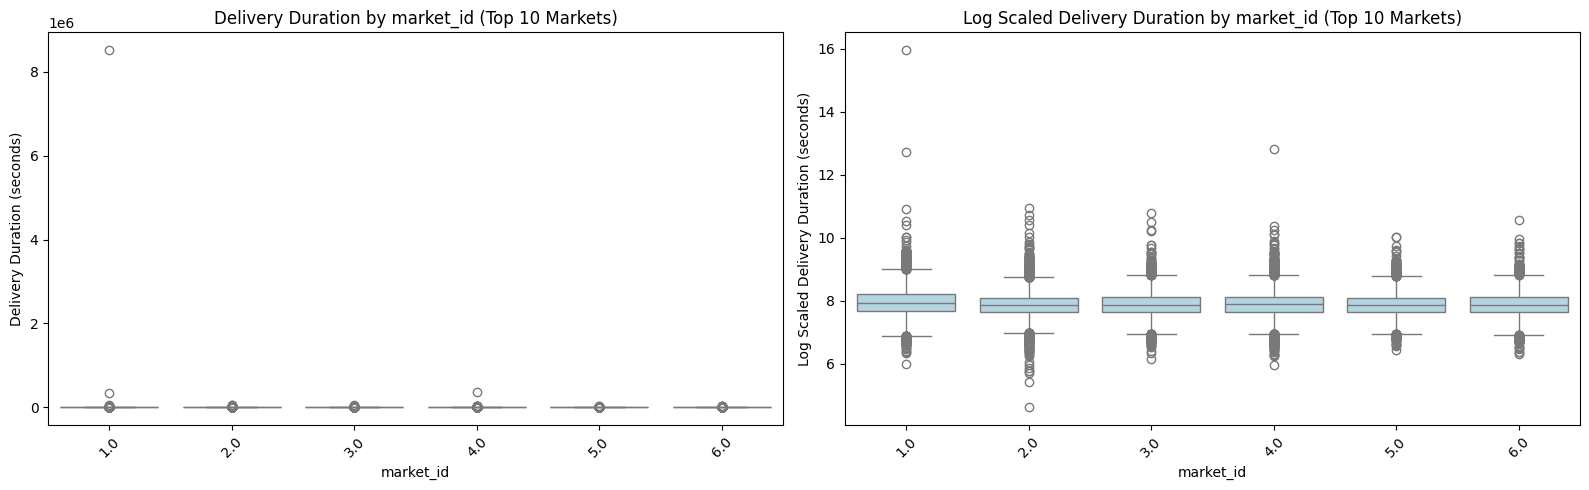

In [53]:
# Select top 10 restaurant categories for visualization
top_categories = (
    data["market_id"].value_counts()
    .head(10)
    .index
)

# Subset data and compute log-transformed delivery duration
df_plot = data[data["market_id"].isin(top_categories)].copy()
df_plot["log_delivery_duration"] = np.log1p(df_plot["delivery_duration"])

# Create side-by-side boxplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), squeeze=False)
axes = axes.ravel()

# Raw scale
sns.boxplot(
    x="market_id",
    y="delivery_duration",
    data=df_plot,
    color="lightblue",
    ax=axes[0]
)
axes[0].set_title("Delivery Duration by market_id (Top 10 Markets)")
axes[0].set_xlabel("market_id")
axes[0].set_ylabel("Delivery Duration (seconds)")
axes[0].tick_params(axis="x", rotation=45)

# Log scale
sns.boxplot(
    x="market_id",
    y="log_delivery_duration",
    data=df_plot,
    color="lightblue",
    ax=axes[1]
)
axes[1].set_title("Log Scaled Delivery Duration by market_id (Top 10 Markets)")
axes[1].set_xlabel("market_id")
axes[1].set_ylabel("Log Scaled Delivery Duration (seconds)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


## Modeling Plan

Building on insights from the exploratory analysis, the next phase of the project will follow a structured modeling workflow designed to capture both global delivery patterns and localized operational behaviors. This approach emphasizes interpretability, segmentation, and complementary modeling strategies that work together to improve prediction accuracy and business relevance.

### 1. Feature Engineering  
Feature creation will form the foundation of the modeling workflow. Drawing on relationships identified during EDA, new variables will be engineered to capture operational load, temporal patterns, and order complexity.  

Examples include:

- **Temporal Features:** hour of day, day of week, weekend flag, and cyclical time encodings.  
- **Marketplace Load Features:** dasher utilization ratios and congestion metrics reflecting real-time delivery demand.  
- **Order Complexity Features:** average item price, distinct-to-total item ratio, and item price variability.  
- **Target Transformations:** log-scaling of delivery duration to stabilize variance and reduce skewness.  
- **Categorical Encoding:** one-hot encoding for restaurant type and market identifiers.

These engineered features will serve as both direct model inputs and as dimensions for clustering analysis in the next stage. Prior to modeling, multicollinearity will be assessed to prevent redundant predictors, and dimensionality reduction techniques (e.g., feature selection) may be applied to mitigate the effects of the curse of dimensionality.

---

### 2. Unsupervised Segmentation  
An unsupervised learning layer will be applied to uncover latent patterns among restaurants or markets. Clustering (e.g., *k*-means) will group restaurants with similar operational or fulfillment characteristics based on metrics such as average preparation time, order volume, and historical delivery duration.

Each restaurant will receive a corresponding `cluster_id` feature, which will be added to the supervised dataset. This provides the model with structured information about underlying operational segments, allowing it to learn differentiated response patterns across groups (e.g., fast-service vs. full-service restaurants).

---

### 3. Supervised Learning  
Supervised regression models will be developed on the enriched dataset that includes both engineered and cluster-derived features. The modeling sequence will proceed from interpretable baselines to nonlinear ensemble methods:

1. **Linear Regression / Ridge / Lasso:** establish performance baselines and evaluate global linear relationships.  
2. **Random Forest Regressor:** capture nonlinearities and interactions between engineered features.  
3. **LightGBM or XGBoost:** refine predictive performance and test scalability across larger feature sets.  

This layered approach ensures that both global patterns and segment-specific effects are captured effectively.

---

### 4. Evaluation and Explainability  
Model evaluation will use standard regression metrics (MAE, RMSE, R²) alongside interpretability techniques to assess not only *how well* the model predicts but *why* it performs as it does.

- **Global Evaluation:** compare performance of baseline vs. cluster-enhanced models.  
- **Feature Importance and SHAP Values:** quantify the impact of operational, temporal, and clustering features.  
- **Residual Analysis:** identify systematic under- or over-predictions tied to specific restaurant clusters or markets.

This interpretive layer ensures that modeling insights remain actionable, highlighting operational factors that consistently extend or reduce delivery durations.

---

### Summary  
This integrated modeling framework combines engineered features, unsupervised segmentation, and complementary regression models to create a scalable, explainable prediction system. By pairing interpretable linear baselines with nonlinear and cluster-aware models, the project aims to produce insights that are both statistically robust and operationally meaningful, directly supporting the goal of improving delivery reliability and customer experience. 

Ideally the model would not only provide more accurate delivery time predictions for DoorDash customers, but also help identify merchants who may need operational support to improve performance or, in extreme cases, highlight those at risk of deplatforming due to repeated delivery issues. 
